# Import libraries

In [1]:
import os
import sys
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import importlib
from process_frames import Processor

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
import joblib
import seaborn as sn

# Choose options
If you want to process image, set PROCESS_IMAGES to True
If you want to process data, set PROCESS_DATA to True

In [2]:
PROCESS_IMAGES = True
PROCESS_DATA = True

# List images

In [3]:
path = os.getcwd()
os.chdir(path)
sys.path.append(path)
sys.path.append(os.path.join(path, 'scripts'))

path_color = '../data/color/'
path_depth = '../data/depth/'
path_mosaic = '../data/mosaic/'

#Create mosaic path if it not exits
if (not os.path.isdir(path_mosaic)):
    os.mkdir(path_mosaic)

file_list = glob.glob(path_depth+"*")
file_list = [os.path.basename(filename) for filename in file_list]

print(len(file_list),"images found")

2069 images found


# Generate data

In [4]:
if PROCESS_IMAGES:
    processor = Processor()
    areas = {filename: processor.process_image(depth_filename=os.path.join(path_depth, filename),
                          color_filename=os.path.join(path_color, filename),
                          mosaic_path=path_mosaic) for filename in file_list}
    # Prepare data
    remove_areas = []
    for area in areas:    
        if areas[area] is None:  
            remove_areas.append(area)
    for remove in remove_areas:
        del areas[remove]
    areas_dataframe = pd.DataFrame.from_dict(areas, orient='index',
         columns=['area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
    areas_dataframe.index.name = 'uuid'
    areas_dataframe.index = areas_dataframe.index.str.replace('.npy', '',)
    print("Generated data")
    display(areas_dataframe.head())
    # Read csv file with weights
    weight_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid.csv'), usecols=['uuid', 'id', 'sex', 'weight'])
    print("Loaded data")
    display(weight_data.head())
    # Save calculated information in csv file
    mix = pd.merge(weight_data, areas_dataframe, on='uuid', how='inner')
    weight_col = mix.pop('weight')
    x_col = mix.pop('x')
    y_col = mix.pop('y')
    centroid_x_col = mix.pop('centroid_x')
    centroid_y_col = mix.pop('centroid_y')
    orientation_col = mix.pop('orientation')
    center_dist_col = mix.pop('center distance')
    mix.insert(12, 'weight', weight_col)
    mix.insert(13, 'x', x_col)
    mix.insert(14, 'y', y_col)
    mix.insert(15, 'centroid_x', centroid_x_col)
    mix.insert(16, 'centroid_y', centroid_y_col)
    mix.insert(17, 'center distance', center_dist_col)
    mix.insert(18, 'orientation', orientation_col)
    mix.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'))
    print("Final data")
    display(mix.head())

Generated data


,area,x,y,width,height,MA,ma,centroid_x,centroid_y,orientation,% area,center distance,eccentricity,perimeter,symmetry
uuid,,,,,,,,,,,,,,,
0018b76693a14e20bce3027ff67dc055,273025.289744,196,119,576,346,304.146881,563.124084,258.377880,474.895100,-1.348229,50.015605,54.111530,236.961711,1727.474300,0.574291
00607e166c6e4054ab75451aacfbe32d,265083.619523,186,118,592,339,307.100464,574.335022,257.150605,476.758842,-1.407047,51.423913,55.476469,242.667480,1757.658066,0.575876
00635ae09a834ebf86ee85c58c12ff82,201016.798552,109,108,565,245,250.569244,523.746887,235.902665,407.500741,-1.551654,49.959682,17.000402,229.959701,1552.628628,0.482139
0066778f47734ca7a71be790f562c551,271063.185330,195,120,578,344,306.356812,563.428528,259.034342,475.183414,-1.366295,50.484331,54.608132,236.430333,1733.131154,0.575517
006d8cf500f14647a8de9ecf71951066,194461.430407,203,77,441,359,214.100098,504.326263,249.268163,400.243665,-1.016888,41.053033,25.500242,228.312356,1436.261097,0.698023


Loaded data


,uuid,id,sex,weight
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,24.5
1,960fd92c91f541f6b85889426c39a0fe,0261,1,27.1
2,ca10f050724d47f5971c3530ef341a8d,0236,0,25.5
3,3c4dcc3c6d83425dab0d0acd75227f99,0236,0,25.5
4,46d3f67bbf684992ac945ce7c1991ae7,0238,1,25.8


Final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,226.871475,589.829285,46.219501,272.225972,1797.356550,0.734787,24.5,103,105,291.266698,390.794758,61.080786,-1.305798
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,217.185989,681.104919,58.533350,322.774750,1741.817446,0.836852,27.1,80,202,328.944662,427.000459,88.995256,1.441417
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,167.003387,671.221436,36.034621,325.056950,1568.812394,0.836188,25.5,195,103,270.915334,489.139166,72.103182,1.183508
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,188.982895,637.330017,60.039439,304.333294,1589.508790,0.920896,25.8,117,181,288.285815,444.695562,52.534048,1.520453
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,196.767181,568.790527,41.696390,266.835783,1437.391040,0.753610,25.5,171,96,297.283394,422.638323,57.299576,-1.087220


# Process data

Load final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,226.871475,589.829285,46.219501,272.225972,1797.356550,0.734787,24.5,103,105,291.266698,390.794758,61.080786,-1.305798
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,217.185989,681.104919,58.533350,322.774750,1741.817446,0.836852,27.1,80,202,328.944662,427.000459,88.995256,1.441417
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,167.003387,671.221436,36.034621,325.056950,1568.812394,0.836188,25.5,195,103,270.915334,489.139166,72.103182,1.183508
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,188.982895,637.330017,60.039439,304.333294,1589.508790,0.920896,25.8,117,181,288.285815,444.695562,52.534048,1.520453
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,196.767181,568.790527,41.696390,266.835783,1437.391040,0.753610,25.5,171,96,297.283394,422.638323,57.299576,-1.087220


1002 images loaded
X data


,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry
1840,1,207571.551845,370,189,163.405807,411.348663,62.771863,188.750010,1050.465072,0.950670
223,0,291113.058414,548,212,175.713989,637.098816,54.070946,306.194177,1522.430582,0.875868
292,0,169880.815319,457,199,183.904510,448.155670,63.107904,204.342015,1158.447827,0.851904
872,0,233896.198850,711,273,234.175888,770.697876,53.305238,367.129701,1970.729133,0.698458
332,1,314248.422837,595,275,185.276642,658.309998,47.642667,315.849893,1658.177837,0.923788


y data


,weight
1840,24.0
223,25.5
292,27.7
872,27.2
332,22.9


Correlation matrix


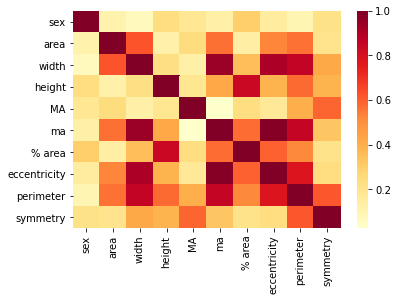

In [5]:
#Load file data
file_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'), usecols=['uuid', 'id', 'sex', 'weight', 'area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
print("Load final data")
display(file_data.head())
file_data = file_data[file_data['symmetry']>0.65]
#file_data = file_data[file_data['area']>200000]
#file_data = file_data[file_data['% area']>0.5]
file_data = shuffle(file_data)

print(len(file_data),"images loaded")

X = file_data.loc[:, 'sex':'symmetry']
print("X data")
display(X.head())

y = file_data.loc[:, ['weight']]
print("y data")
display(y.head())

#Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

if PROCESS_DATA:
    print("Correlation matrix")
    corrMatrix = X.corr().abs()
    sn.heatmap(corrMatrix, cmap="YlOrRd")
    plt.savefig(os.path.join("..", 'data', 'heatmap.jpeg'), bbox_inches='tight')
    
    
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    linearRegression = LinearRegression()   
    ridge = Ridge()
    ridgecv = RidgeCV()
    lasso = Lasso()
    lassocv = LassoCV()
    lassolars = LassoLars()
    lassolarscv = LassoLarsCV()
    decisionTree = DecisionTreeRegressor()

    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[linearRegression], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[ridge], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[ridgecv], 'classifier__fit_intercept': [True,False], 'classifier__scoring':['r2']},
                      {'classifier':[lasso], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1), 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassocv], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassolars], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[lassolarscv], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[decisionTree], 'classifier__criterion':['mse', 'friedman_mse', 'mae'], 'classifier__max_features': ['auto', 'sqrt', 'log2']}
                 ]

    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                       'neg_root_mean_squared_error', 'neg_median_absolute_error']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      #cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods,
                      iid=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())

    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'ridge': ridge,
                 'ridgecv': ridgecv,
                 'lasso': lasso,
                 'lassocv': lassocv,
                 'lassolars': lassolars,
                 'lassolarscv': lassolarscv,
                 'decisionTree': decisionTree
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump'))
else:
    #Load last model
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    linearRegression = models['linearRegression']
    ridge = models['ridge']
    ridgecv = models['ridgecv']
    lasso= models['lasso']
    lassocv = models['lassocv']
    lassolars = models['lassolars']
    lassolarscv = models['lassolarscv']
    decisionTree = models['decisionTree']

In [6]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)

resultados = pd.DataFrame(gs.cv_results_)
resultados['param_classifier'] = resultados.param_classifier.astype(str).str.split('(', expand=True)[0]
resultados.head()
mejores_resultados_por_tipo_de_modelo = pd.pivot_table(data=resultados,
               index='param_classifier',
               values = ['mean_test_r2', 'std_test_r2',
                            'mean_test_explained_variance', 'std_test_explained_variance',
                            'mean_test_max_error', 'std_test_max_error',
                            'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
                            'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 
                             'mean_test_neg_root_mean_squared_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 'mean_test_neg_mean_absolute_error',
                         'mean_test_neg_root_mean_squared_error', 'std_test_r2', 'std_test_explained_variance', 'std_test_max_error', 'std_test_neg_mean_absolute_error',
                        ], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo.sort_values(by='mean_test_r2', ascending=False, inplace=True)
(mejores_resultados_por_tipo_de_modelo).round(4)

Best model: DecisionTreeRegressor(max_features='auto')
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,std_test_r2,std_test_explained_variance,std_test_max_error,std_test_neg_mean_absolute_error
param_classifier,,,,,,,,,
DecisionTreeRegressor,0.9095,0.9100,-9.6000,-0.3403,-1.3560,0.0908,0.0909,3.4871,0.2088
LinearRegression,0.5642,0.5659,-9.9656,-2.3575,-3.0530,0.0508,0.0506,0.9835,0.1502
LassoCV,0.5638,0.5655,-9.7070,-2.3626,-3.0544,0.0559,0.0544,1.0474,0.1646
LassoLarsCV,0.5631,0.5648,-9.9143,-2.3649,-3.0570,0.0511,0.0509,1.0359,0.1496
RidgeCV,0.5624,0.5644,-9.4767,-2.3698,-3.0595,0.0499,0.0498,1.0305,0.1459
Ridge,0.5538,0.5564,-9.1656,-2.4019,-3.0895,0.0609,0.0577,0.9661,0.1721
Lasso,0.3458,0.4105,-7.1226,-2.6244,-3.7290,0.3687,0.1264,1.2307,0.4786
LassoLars,0.3457,0.4104,-7.1899,-2.6247,-3.7291,0.3686,0.1263,1.2288,0.4786


In [7]:
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Explained vairance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))

R2 score: 0.8905962402974695
Explained vairance score: 0.8906722347695754
Max error: 11.499999999999995
Mean absolute error: 0.3667774086378781


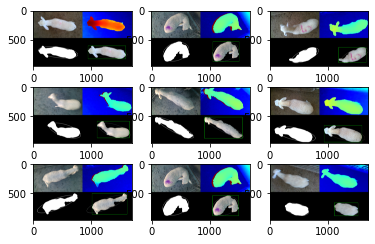

In [8]:
files = []
differences = []
for i in range(0,len(best_estimator_predictions)):
    difference = abs(best_estimator_predictions[i]-y_test.iloc[i].weight) 
    if difference>2:
        uuid = file_data.loc[y_test.iloc[i].name].uuid
        files.append(uuid)
        differences.append(difference)
"""
print(differences)
print(dif_total)

file_data_new = file_data[file_data['uuid'].isin(files)]
display(file_data_new)
"""

max_images = 9 if (len(files)>9)  else len(files)
for i in range(0,max_images):
    plt.subplot(3,3,i+1)
    img=mpimg.imread(os.path.join("..", 'data', 'mosaic', files[i]+'_mosaico.png'))
    imgplot = plt.imshow(img)

plt.savefig(os.path.join("..", 'data', 'mismatch.jpeg'), bbox_inches='tight')